# Translation in Vachan-API V2
The vachan-api, which is the API server for vachan-engine suite, comes with set of translation APIs that enables token-replacement translation between a Gateway Language and no-resource minority lanuage.

To be able to run the examples in this notebook
- Need to pull the code from https://github.com/Bridgeconn/vachan-api/ version-2 branch
- [set up the app locally](https://github.com/Bridgeconn/vachan-api/tree/version-2#how-to-set-up-locally-for-development-and-testing)
- Use the apps venv
- start the app from the vachan-api/app folder
    ```
    >>>uvicorn main:app
    ```

### Main differences between translation in V1 and V2
In V1 we were doing a token replacement translation on Bible contents to provide a draft 0 for the human translators to start working with. There we had the following work flow:
- Tokenize a bible or a set of books and obtain a unique list of tokens
- Get these tokens translated by users
- Do a string replacement of tokens on source USFM files to get drat 0

In v2 we  continue to follow the token-replacement approach, while bringing major improvemnts in the following aspects:
- In v1, only one translation was accepted for one token. Here we allow **multiple senses/translation** for a token and context based application of these translations
- We have **Translation Memory** which allows the knowledge we gain from one translation to be used for giving **suggestions** later in the project or even in later projects between the same language pairs
- We have capabilities to extend translations outside of just Bible, and allows apps to be built for **other kinds of content translations** like notes, stories, commentaries etc
- Allows project **export** in an alignment format


# Translation Module Workflow 

### Upload a bible to be used as source/reference

NB: It is not mandatory that the Bible be uploaded like this to the server. If a user of the translation app wants to user a USFM file of his own as source/reference in his project, it is possible. It is demostarted below. This Bible upload is to show that a user can make use of a Bible that is available on the cloud as his source too.

In [1]:
import json
import requests

BASE_URL = "http://127.0.0.1:8000/v2/"
headers = {"contentType": "application/json", "accept": "application/json"}

In [3]:
ver_data = {
    "versionAbbreviation": "XYZ",
    "versionName": "Xyz version to test",
    "revision": "1",
    "metaData": {"owner": "someone", "access-key": "123xyz"}
}

src_data = {
    "contentType": "bible",
    "language": "hi",
    "version": "XYZ",
    "revision": 1,
    "year": 2020,
    "license": "CC-BY-SA",
    "metaData": {"owner": "someone", "access-key": "123xyz"}
}

gospel_books_data = [
        {"USFM":"\\id mat\n\\c 1\n\\p\n\\v 1 अब्राहम की सन्तान, दाऊद की सन्तान, यीशु मसीह की वंशावली ।"+
         "\\v 2 अब्राहम से इसहाक उत्पन्न हुआ, इसहाक से याकूब उत्पन्न हुआ, और याकूब से यहूदा और उसके भाई उत्पन्न हुए।"+
         "\\v 3 यहूदा और तामार से पेरेस व जेरह उत्पन्न हुए, और पेरेस से हेस्रोन उत्पन्न हुआ, और हेस्रोन से एराम उत्पन्न हुआ।"+
         "\\v 4 एराम से अम्मीनादाब उत्पन्न हुआ, और अम्मीनादाब से नहशोन, और नहशोन से सलमोन उत्पन्न हुआ। "+
         "\\v 5 सलमोन और राहाब से बोअज उत्पन्न हुआ, और बोअज और रूत से ओबेद उत्पन्न हुआ, और ओबेद से यिशै उत्पन्न हुआ।"+
         "\\v 6 और यिशै से दाऊद राजा उत्पन्न हुआ। और दाऊद से सुलैमान उस स्त्री से उत्पन्न हुआ जो पहले ऊरिय्याह की पत्नी थी।"+
         "\\v 7 सुलैमान से रहबाम उत्पन्न हुआ, और रहबाम से अबिय्याह उत्पन्न हुआ, और अबिय्याह से आसा उत्पन्न हुआ।"+
         "\\v 8 आसा से यहोशाफात उत्पन्न हुआ, और यहोशाफात से योराम उत्पन्न हुआ, और योराम से उज्जियाह उत्पन्न हुआ।"+
         "\\v 9 उज्जियाह से योताम उत्पन्न हुआ, योताम से आहाज उत्पन्न हुआ, और आहाज से हिजकिय्याह उत्पन्न हुआ।"+
         "\\v 10 हिजकिय्याह से मनश्शे उत्पन्न हुआ, मनश्शे से आमोन उत्पन्न हुआ, और आमोन से योशिय्याह उत्पन्न हुआ।"},
        {"USFM": "\\id mrk\n\\c 1\n\\p\n\\v 1 परमेश्वर के पुत्र यीशु मसीह के सुसमाचार का आरम्भ।"+
         "\\v 2 जैसे यशायाह भविष्यद्वक्ता की पुस्तक में लिखा है: “देख, मैं अपने दूत को तेरे आगे भेजता हूँ, जो तेरे लिये मार्ग सुधारेगा।"+
         "\\v 3 जंगल में एक पुकारनेवाले का शब्द हो रहा है कि प्रभु का मार्ग तैयार करो, और उसकी सड़कें सीधी करो।”"+
         "\\v 4 यूहन्ना आया, जो जंगल में बपतिस्मा देता, और पापों की क्षमा के लिये मन फिराव के बपतिस्मा का प्रचार करता था।"+
         "\\v 5 सारे यहूदिया के, और यरूशलेम के सब रहनेवाले निकलकर उसके पास गए, और अपने पापों को मानकर यरदन नदी में उससे बपतिस्मा लिया।"+
         "\\v 6 यूहन्ना ऊँट के रोम का वस्त्र पहने और अपनी कमर में चमड़े का कमरबन्द बाँधे रहता था और टिड्डियाँ और वनमधु खाया करता था।"+
         "\\v 7 और यह प्रचार करता था, “मेरे बाद वह आनेवाला है, जो मुझसे शक्तिशाली है; मैं इस योग्य नहीं कि झुककर उसके जूतों का फीता खोलूँ।"+
         "\\v 8 मैंने तो तुम्हें पानी से बपतिस्मा दिया है पर वह तुम्हें पवित्र आत्मा से बपतिस्मा देगा।”"},
        {"USFM":"\\id luk\n\\c 1\n\\p\n\\v 1 बहुतों ने उन बातों का जो हमारे बीच में बीती हैं, इतिहास लिखने में हाथ लगाया है।"+
         "\\v 2 जैसा कि उन्होंने जो पहले ही से इन बातों के देखनेवाले और वचन के सेवक थे हम तक पहुँचाया।"+
         "\\v 3 इसलिए हे श्रीमान थियुफिलुस मुझे भी यह उचित मालूम हुआ कि उन सब बातों का सम्पूर्ण हाल आरम्भ से ठीक-ठीक जाँच करके उन्हें तेरे लिये क्रमानुसार लिखूँ,"+
         "\\v 4 कि तू यह जान ले, कि वे बातें जिनकी तूने शिक्षा पाई है, कैसी अटल हैं।"},
        {"USFM": "\\id jhn\n\\c 1\n\\p\n\\v 1 आदि में वचन था, और वचन परमेश्वर के साथ था, और वचन परमेश्वर था।"+
         "\\v 2 यही आदि में परमेश्वर के साथ था।"+
         "\\v 3 सब कुछ उसी के द्वारा उत्पन्न हुआ और जो कुछ उत्पन्न हुआ है, उसमें से कोई भी वस्तु उसके बिना उत्पन्न न हुई।"+
         "\\v 4 उसमें जीवन था; और वह जीवन मनुष्यों की ज्योति था।"}
]

In [4]:
resp = requests.post(BASE_URL+"versions", headers=headers, json=ver_data)
print(resp.json()['message'])

resp = requests.post(BASE_URL+"sources", headers=headers, json=src_data)
print(resp.json()['message'])
source_name = resp.json()['data']['sourceName']

resp = requests.post(BASE_URL+"bibles/"+source_name+"/books", headers=headers,
json=gospel_books_data)
print(resp.json()['message'])


Version created successfully
Source created successfully
Bible books uploaded and processed successfully


## A Translation Project
A translation project on vachan-api could correspond to an AutographaMT project. But it doesn't limit to just one app, AutographaMT. If we want separate tranlsation client tools to be built, for example to support translation of other contents like notes, stories etc, the same could be extended on to those apps' projects as well.

In [5]:
project_post_data = {
    "projectName": "Hindi-Malayalam Demo Project",
    "sourceLanguageCode": "hi",
    "targetLanguageCode": "ml"
}

prj_creation_resp = requests.post(BASE_URL+"autographa/projects", headers=headers, json=project_post_data)
print(prj_creation_resp.json()["message"])
project_id = prj_creation_resp.json()['data']['projectId']



Project created successfully


In [6]:
print(project_id)
print(prj_creation_resp.json()["data"]["metaData"]["books"])

100000
[]


In [8]:
bible_books = {
    "mat":  "\\id MAT\n\\c 1\n\\p\n\\v 1 इब्राहीम के वंशज दाऊद के पुत्र यीशु मसीह की वंशावली इस "+
            "प्रकार है:\n\\v 2 इब्राहीम का पुत्र था इसहाक और इसहाक का पुत्र हुआ याकूब। फिर याकूब "+
            "से यहूदा और उसके भाई उत्पन्न हुए।\n\\v 3 यहूदा के बेटे थे फिरिस और जोरह। (उनकी माँ "+
            "का नाम तामार था।) फिरिस, हिस्रोन का पिता था। हिस्रोन राम का पिता था।",
    "mrk":    "\\id MRK\n\\c 1\n\\p\n\\v 1 यह परमेश्वर के पुत्र यीशु मसीह के शुभ संदेश का प्रारम्भ"+
            " है।\n\\v 2 भविष्यवक्ता यशायाह की पुस्तक में लिखा है कि: “सुन! मैं अपने दूत को तुझसे"+
            " पहले भेज रहा हूँ। वह तेरे लिये मार्ग तैयार करेगा।”\n\\v 3 “जंगल में किसी पुकारने "+
            "वाले का शब्द सुनाई दे रहा है: ‘प्रभु के लिये मार्ग तैयार करो। और उसके लिये राहें "+
            "सीधी बनाओ।’”\n\\v 4 यूहन्ना लोगों को जंगल में बपतिस्मा देते आया था। उसने लोगों से"+
            " पापों की क्षमा के लिए मन फिराव का बपतिस्मा लेने को कहा।\n\\v 5 फिर समूचे यहूदिया"+
            " देश के और यरूशलेम के लोग उसके पास गये और उस ने यर्दन नदी में उन्हें बपतिस्मा दिया"+
            "। क्योंकि उन्होंने अपने पाप मान लिये थे।"
}

source_name = "hi_XYZ_1_bible"

project_update_data = {
	"projectId":project_id,
    "uploadedBooks":[bible_books['mat'], bible_books['mrk']],
    "selectedBooks":{"bible": source_name,
    				 "books": ['luk', 'jhn']}

}


In [9]:
project_update_resp = requests.put(BASE_URL+"autographa/projects", headers=headers, json=project_update_data)
print(project_update_resp.json()['message'])
print(project_update_resp.json()['data']['metaData']['books'])

Project updated successfully
['luk', 'jhn', 'mat', 'mrk']


In [10]:
project_source = requests.get(BASE_URL+"autographa/project/sentences?project_id="+str(project_id), headers=headers)
for item in project_source.json():
    print(item['surrogateId'], item['sentence'])

mat 1:1 इब्राहीम के वंशज दाऊद के पुत्र यीशु मसीह की वंशावली इस प्रकार है:
mat 1:2 इब्राहीम का पुत्र था इसहाक और इसहाक का पुत्र हुआ याकूब। फिर याकूब से यहूदा और उसके भाई उत्पन्न हुए।
mat 1:3 यहूदा के बेटे थे फिरिस और जोरह। (उनकी माँ का नाम तामार था।) फिरिस, हिस्रोन का पिता था। हिस्रोन राम का पिता था।
mrk 1:1 यह परमेश्वर के पुत्र यीशु मसीह के शुभ संदेश का प्रारम्भ है।
mrk 1:2 भविष्यवक्ता यशायाह की पुस्तक में लिखा है कि: “सुन! मैं अपने दूत को तुझसे पहले भेज रहा हूँ। वह तेरे लिये मार्ग तैयार करेगा।”
mrk 1:3 “जंगल में किसी पुकारने वाले का शब्द सुनाई दे रहा है: ‘प्रभु के लिये मार्ग तैयार करो। और उसके लिये राहें सीधी बनाओ।’”
mrk 1:4 यूहन्ना लोगों को जंगल में बपतिस्मा देते आया था। उसने लोगों से पापों की क्षमा के लिए मन फिराव का बपतिस्मा लेने को कहा।
mrk 1:5 फिर समूचे यहूदिया देश के और यरूशलेम के लोग उसके पास गये और उस ने यर्दन नदी में उन्हें बपतिस्मा दिया। क्योंकि उन्होंने अपने पाप मान लिये थे।
luk 1:1 बहुतों ने उन बातों का जो हमारे बीच में बीती हैं, इतिहास लिखने में हाथ लगाया है।
luk 1:2 जैसा

## Tokenization

We follow a token replacement translation approach similar to the older version, which is meant to be used between similar languages, for creating a draft 0 which can be used as a starting point for human translators.

In [11]:
def pretty_print_tokens(tokens):
    for token in tokens:
        print(token['token'],end="\t\t")
        print("occurrences:",[(item['sentenceId'], item['offset']) for item in token['occurrences']], end="\t")
        print("translation-suggestions:", [key for key in token['translations']])

In [12]:
# default
default_tokens_resp = requests.get(BASE_URL+"autographa/project/tokens?project_id="+str(project_id))
print(default_tokens_resp.json()[0])


{'token': 'इब्राहीम के', 'occurrences': [{'sentenceId': 41001001, 'offset': [0, 11]}], 'translations': {}}


In [13]:
pretty_print_tokens(default_tokens_resp.json())

इब्राहीम के		occurrences: [(41001001, [0, 11])]	translation-suggestions: []
वंशज		occurrences: [(41001001, [12, 16])]	translation-suggestions: []
दाऊद के		occurrences: [(41001001, [17, 24])]	translation-suggestions: []
पुत्र		occurrences: [(41001001, [25, 30]), (42001001, [15, 20])]	translation-suggestions: []
यीशु		occurrences: [(41001001, [31, 35]), (42001001, [21, 25])]	translation-suggestions: []
मसीह की		occurrences: [(41001001, [36, 43])]	translation-suggestions: []
वंशावली		occurrences: [(41001001, [44, 51])]	translation-suggestions: []
इस प्रकार है		occurrences: [(41001001, [52, 64])]	translation-suggestions: []
इब्राहीम का		occurrences: [(41001002, [0, 11])]	translation-suggestions: []
पुत्र था		occurrences: [(41001002, [12, 20])]	translation-suggestions: []
इसहाक और		occurrences: [(41001002, [21, 29])]	translation-suggestions: []
इसहाक का		occurrences: [(41001002, [30, 38])]	translation-suggestions: []
पुत्र हुआ		occurrences: [(41001002, [39, 48])]	translation-suggestions: []

In [15]:
# for a portion of the source

# some_token_resp = requests.get(BASE_URL+"autographa/project/tokens?project_id="+str(project_id)+"&books=luk")

# some_token_resp = requests.get(BASE_URL+"autographa/project/tokens?project_id="+str(project_id)
#                                +"&books=luk&books=jhn")


# some_token_resp = requests.get(BASE_URL+"autographa/project/tokens?project_id="+str(project_id)+
#                                "&sentence_id_range=42001000&sentence_id_range=42001999")

some_token_resp = requests.get(BASE_URL+"autographa/project/tokens?project_id="+str(project_id)+
                               "&sentence_id_list=42001001")


# some_token_resp = requests.get(BASE_URL+"autographa/project/tokens?project_id="+str(project_id)+
#                                "&sentence_id_list=42001001&sentence_id_list=43001001")


pretty_print_tokens(some_token_resp.json())



यह परमेश्वर के		occurrences: [(42001001, [0, 14])]	translation-suggestions: []
पुत्र		occurrences: [(42001001, [15, 20])]	translation-suggestions: []
यीशु		occurrences: [(42001001, [21, 25])]	translation-suggestions: []
मसीह के		occurrences: [(42001001, [26, 33])]	translation-suggestions: []
शुभ		occurrences: [(42001001, [34, 37])]	translation-suggestions: []
संदेश का		occurrences: [(42001001, [38, 46])]	translation-suggestions: []
प्रारम्भ है		occurrences: [(42001001, [47, 58])]	translation-suggestions: []


In [17]:
# For different kinds of tokens

# token_resp = requests.get(BASE_URL+"autographa/project/tokens?project_id="+str(project_id)+"&sentence_id_list=42001001"
#                          +"&include_phrases=False")

token_resp = requests.get(BASE_URL+"autographa/project/tokens?project_id="+str(project_id)+"&sentence_id_list=42001001"
                         +"&include_phrases=False&include_stopwords=True")

pretty_print_tokens(token_resp.json())


यह		occurrences: [(42001001, [0, 2])]	translation-suggestions: []
परमेश्वर		occurrences: [(42001001, [3, 11])]	translation-suggestions: []
के		occurrences: [(42001001, [12, 14]), (42001001, [31, 33])]	translation-suggestions: []
पुत्र		occurrences: [(42001001, [15, 20])]	translation-suggestions: []
यीशु		occurrences: [(42001001, [21, 25])]	translation-suggestions: []
मसीह		occurrences: [(42001001, [26, 30])]	translation-suggestions: []
शुभ		occurrences: [(42001001, [34, 37])]	translation-suggestions: []
संदेश		occurrences: [(42001001, [38, 43])]	translation-suggestions: []
का		occurrences: [(42001001, [44, 46])]	translation-suggestions: []
प्रारम्भ		occurrences: [(42001001, [47, 55])]	translation-suggestions: []
है		occurrences: [(42001001, [56, 58])]	translation-suggestions: []


## Tweek the Tokenization

We can control how the tokenization algorithm works by defining our own set of stopwords or puctuations to be used in the project. This would allow the user to choose how the tokenization is done, as per the specific needs of his work and language's nature.

In [22]:
hi_sws =  {
    "prepositions": [
      "कोई",
#      "यह",
      "इस",
      "इसे",
      "उस",
      "कई",
      "इसी",
      "अभी",
      "जैसे"
    ],
    "postpositions": [
#       "के",
#       "का",
#       "की",
      "में",
      "है",
      "और",
      "से",
      "हैं",
      "को",
      "पर"
    ]
  }

In [23]:
project_edit_data = {
	"projectId":project_id,
    "stopwords":hi_sws
}
project_edit_resp = requests.put(BASE_URL+"autographa/projects", headers=headers, json=project_edit_data)
print(project_edit_resp.json()['message'])


Project updated successfully


In [24]:
token_resp = requests.get(BASE_URL+"autographa/project/tokens?project_id="+str(project_id)+"&sentence_id_list=42001001"
                         +"&include_phrases=True&include_stopwords=False")
pretty_print_tokens(token_resp.json())

यह		occurrences: [(42001001, [0, 2])]	translation-suggestions: []
परमेश्वर		occurrences: [(42001001, [3, 11])]	translation-suggestions: []
के		occurrences: [(42001001, [12, 14]), (42001001, [31, 33])]	translation-suggestions: []
पुत्र		occurrences: [(42001001, [15, 20])]	translation-suggestions: []
यीशु		occurrences: [(42001001, [21, 25])]	translation-suggestions: []
मसीह		occurrences: [(42001001, [26, 30])]	translation-suggestions: []
शुभ		occurrences: [(42001001, [34, 37])]	translation-suggestions: []
संदेश		occurrences: [(42001001, [38, 43])]	translation-suggestions: []
का		occurrences: [(42001001, [44, 46])]	translation-suggestions: []
प्रारम्भ है		occurrences: [(42001001, [47, 58])]	translation-suggestions: []


In [26]:
puncts = [',', '"', '!', '.', ':', ';', '\n', '\\','“','”',
        '“','*',
#           '।',
          '?',';',"'","’","(",")","‘","—"]

In [27]:
project_edit_data = {
	"projectId":project_id,
    "punctuations":puncts
}
project_edit_resp = requests.put(BASE_URL+"autographa/projects", headers=headers, json=project_edit_data)
print(project_edit_resp.json()['message'])


Project updated successfully


In [28]:
token_resp = requests.get(BASE_URL+"autographa/project/tokens?project_id="+str(project_id)+"&sentence_id_list=42001001")

pretty_print_tokens(token_resp.json())

यह		occurrences: [(42001001, [0, 2])]	translation-suggestions: []
परमेश्वर		occurrences: [(42001001, [3, 11])]	translation-suggestions: []
के		occurrences: [(42001001, [12, 14]), (42001001, [31, 33])]	translation-suggestions: []
पुत्र		occurrences: [(42001001, [15, 20])]	translation-suggestions: []
यीशु		occurrences: [(42001001, [21, 25])]	translation-suggestions: []
मसीह		occurrences: [(42001001, [26, 30])]	translation-suggestions: []
शुभ		occurrences: [(42001001, [34, 37])]	translation-suggestions: []
संदेश		occurrences: [(42001001, [38, 43])]	translation-suggestions: []
का		occurrences: [(42001001, [44, 46])]	translation-suggestions: []
प्रारम्भ		occurrences: [(42001001, [47, 55])]	translation-suggestions: []
है।		occurrences: [(42001001, [56, 59])]	translation-suggestions: []


## Translate

We do context based translation. It allows the same word to have different senses or translations at different occurances. So, user is required to specify to which all occurances of a token, a particular translation is to be applied.

In [29]:

def pretty_print_draft(sents):
    for item in sents:
        print(item['surrogateId'], item['sentence'])
        print(item['surrogateId'], item['draft'])
        print()

In [30]:
token_resp = requests.get(BASE_URL+"autographa/project/tokens?project_id="+str(project_id)+"&sentence_id_list=41001001")

pretty_print_tokens(token_resp.json())

इब्राहीम		occurrences: [(41001001, [0, 8])]	translation-suggestions: []
के		occurrences: [(41001001, [9, 11]), (41001001, [22, 24])]	translation-suggestions: []
वंशज		occurrences: [(41001001, [12, 16])]	translation-suggestions: []
दाऊद		occurrences: [(41001001, [17, 21])]	translation-suggestions: []
पुत्र		occurrences: [(41001001, [25, 30])]	translation-suggestions: []
यीशु		occurrences: [(41001001, [31, 35])]	translation-suggestions: []
मसीह		occurrences: [(41001001, [36, 40])]	translation-suggestions: []
की		occurrences: [(41001001, [41, 43])]	translation-suggestions: []
वंशावली		occurrences: [(41001001, [44, 51])]	translation-suggestions: []
इस प्रकार है		occurrences: [(41001001, [52, 64])]	translation-suggestions: []


In the previous version we used a list of unique tokens to be translated by user. Then applied this token translation blindly across all occurences without having the provision of using multiple senses for a token in different contexts. Here, we allow the user to choose where to apply a specific translation by asking him to provide the occurance(sentenceId and offset).

In [32]:
token_update_data = [
	{
		"token":"पुत्र",
		"occurrences":[
			{"sentenceId":41001001, "offset":[25,30]}],
		"translation":"പുത്രന്‍"
	},
	{
		"token":"इब्राहीम",
		"occurrences":[
			{"sentenceId":41001002, "offset":[0, 8]}],
		"translation":"അബ്രഹാം"
	}
]
resp = requests.put(BASE_URL+"autographa/project/tokens?project_id="+str(project_id),
	headers=headers, json=token_update_data)
print(resp.json()['message'])
source_sent = requests.get(BASE_URL+"autographa/project/sentences?project_id="+str(project_id)+
                           "&sentence_id_list=41001001&sentence_id_list=41001002&with_draft=True")

pretty_print_draft(source_sent.json())

Token translations saved
mat 1:1 इब्राहीम के वंशज दाऊद के पुत्र यीशु मसीह की वंशावली इस प्रकार है:
mat 1:1 इब्राहीम के वंशज दाऊद के പുത്രന്‍ यीशु मसीह की वंशावली इस प्रकार है:

mat 1:2 इब्राहीम का पुत्र था इसहाक और इसहाक का पुत्र हुआ याकूब। फिर याकूब से यहूदा और उसके भाई उत्पन्न हुए।
mat 1:2 അബ്രഹാം का पुत्र था इसहाक और इसहाक का पुत्र हुआ याकूब। फिर याकूब से यहूदा और उसके भाई उत्पन्न हुए।



As seen in the above example, we can make use of the token's occurence we get from the tokenization response to specify our token translation. This method suits our token based translation approach we use in the previous systems. But it is not mandatory that we stick to that method alone. User can be given the freedom to **select any word or phrase from the source** via the GUI and translate it. This gives the user the **flexibility** to define the tokens as suited most for his need as well as the target language's nature. In turn, this would allow the system to **learn and improve** its tokenization and suggestion via translation memory

In [33]:
token_update_data = [
	{
		"token":"यीशु मसीह",
		"occurrences":[
			{"sentenceId":41001001, "offset":[31, 40]}],
		"translation":"യേശു ക്രിസ്തു"
	}
]
resp = requests.put(BASE_URL+"autographa/project/tokens?project_id="+str(project_id),
	headers=headers, json=token_update_data)
print(resp.json()['message'])
source_sent = requests.get(BASE_URL+"autographa/project/sentences?project_id="+str(project_id)+
                           "&sentence_id_list=41001001&sentence_id_list=41001002&with_draft=True")

pretty_print_draft(source_sent.json())

Token translations saved
mat 1:1 इब्राहीम के वंशज दाऊद के पुत्र यीशु मसीह की वंशावली इस प्रकार है:
mat 1:1 इब्राहीम के वंशज दाऊद के പുത്രന്‍ യേശു ക്രിസ്തു की वंशावली इस प्रकार है:

mat 1:2 इब्राहीम का पुत्र था इसहाक और इसहाक का पुत्र हुआ याकूब। फिर याकूब से यहूदा और उसके भाई उत्पन्न हुए।
mat 1:2 അബ്രഹാം का पुत्र था इसहाक और इसहाक का पुत्र हुआ याकूब। फिर याकूब से यहूदा और उसके भाई उत्पन्न हुए।



## Suggestion
We can use knowledge from previous projects or other data sources, between a language pair, to give translation suggestions for newer projects or even a later occurance of a token in the same project. These suggestions can be context dependant, as the same token could be translated in different ways when they occur with different surrounding words.

In [34]:
# tokenizing with the above knowledge of tokens and translations in the system

token_resp = requests.get(BASE_URL+"autographa/project/tokens?project_id="+str(project_id)+"&books=mrk")

pretty_print_tokens(token_resp.json())

यह		occurrences: [(42001001, [0, 2])]	translation-suggestions: []
परमेश्वर		occurrences: [(42001001, [3, 11])]	translation-suggestions: []
के		occurrences: [(42001001, [12, 14]), (42001001, [31, 33]), (42001003, [60, 62]), (42001004, [77, 79]), (42001005, [36, 38])]	translation-suggestions: []
पुत्र		occurrences: [(42001001, [15, 20])]	translation-suggestions: ['പുത്രന്\u200d']
यीशु मसीह		occurrences: [(42001001, [21, 30])]	translation-suggestions: ['യേശു ക്രിസ്തു']
शुभ		occurrences: [(42001001, [34, 37])]	translation-suggestions: []
संदेश		occurrences: [(42001001, [38, 43])]	translation-suggestions: []
का		occurrences: [(42001001, [44, 46]), (42001003, [28, 30]), (42001004, [93, 95])]	translation-suggestions: []
प्रारम्भ		occurrences: [(42001001, [47, 55])]	translation-suggestions: []
है।		occurrences: [(42001001, [56, 59])]	translation-suggestions: []
भविष्यवक्ता		occurrences: [(42001002, [0, 11])]	translation-suggestions: []
यशायाह		occurrences: [(42001002, [12, 18])]	translation-su

In [35]:
# drafts before suggestions
resp = requests.get(BASE_URL+"autographa/project/sentences?project_id="+str(project_id)+"&books=mat&books=mrk"+
    "&with_draft=True",headers=headers)
pretty_print_draft(resp.json())

mat 1:1 इब्राहीम के वंशज दाऊद के पुत्र यीशु मसीह की वंशावली इस प्रकार है:
mat 1:1 इब्राहीम के वंशज दाऊद के പുത്രന്‍ യേശു ക്രിസ്തു की वंशावली इस प्रकार है:

mat 1:2 इब्राहीम का पुत्र था इसहाक और इसहाक का पुत्र हुआ याकूब। फिर याकूब से यहूदा और उसके भाई उत्पन्न हुए।
mat 1:2 അബ്രഹാം का पुत्र था इसहाक और इसहाक का पुत्र हुआ याकूब। फिर याकूब से यहूदा और उसके भाई उत्पन्न हुए।

mat 1:3 यहूदा के बेटे थे फिरिस और जोरह। (उनकी माँ का नाम तामार था।) फिरिस, हिस्रोन का पिता था। हिस्रोन राम का पिता था।
mat 1:3 यहूदा के बेटे थे फिरिस और जोरह। (उनकी माँ का नाम तामार था।) फिरिस, हिस्रोन का पिता था। हिस्रोन राम का पिता था।

mrk 1:1 यह परमेश्वर के पुत्र यीशु मसीह के शुभ संदेश का प्रारम्भ है।
mrk 1:1 यह परमेश्वर के पुत्र यीशु मसीह के शुभ संदेश का प्रारम्भ है।

mrk 1:2 भविष्यवक्ता यशायाह की पुस्तक में लिखा है कि: “सुन! मैं अपने दूत को तुझसे पहले भेज रहा हूँ। वह तेरे लिये मार्ग तैयार करेगा।”
mrk 1:2 भविष्यवक्ता यशायाह की पुस्तक में लिखा है कि: “सुन! मैं अपने दूत को तुझसे पहले भेज रहा हूँ। वह तेरे लिये मार्ग तै

In [36]:
# asking translation suggestion for sentences
resp = requests.put(BASE_URL+"autographa/project/suggestions?project_id="+str(project_id)+"&books=mat&books=mrk",
	headers=headers)
pretty_print_draft(resp.json())

mat 1:1 इब्राहीम के वंशज दाऊद के पुत्र यीशु मसीह की वंशावली इस प्रकार है:
mat 1:1 അബ്രഹാം के वंशज दाऊद के പുത്രന്‍ യേശു ക്രിസ്തു की वंशावली इस प्रकार है:

mat 1:2 इब्राहीम का पुत्र था इसहाक और इसहाक का पुत्र हुआ याकूब। फिर याकूब से यहूदा और उसके भाई उत्पन्न हुए।
mat 1:2 അബ്രഹാം का പുത്രന്‍ था इसहाक और इसहाक का പുത്രന്‍ हुआ याकूब। फिर याकूब से यहूदा और उसके भाई उत्पन्न हुए।

mat 1:3 यहूदा के बेटे थे फिरिस और जोरह। (उनकी माँ का नाम तामार था।) फिरिस, हिस्रोन का पिता था। हिस्रोन राम का पिता था।
mat 1:3 यहूदा के बेटे थे फिरिस और जोरह। (उनकी माँ का नाम तामार था।) फिरिस, हिस्रोन का पिता था। हिस्रोन राम का पिता था।

mrk 1:1 यह परमेश्वर के पुत्र यीशु मसीह के शुभ संदेश का प्रारम्भ है।
mrk 1:1 यह परमेश्वर के പുത്രന്‍ യേശു ക്രിസ്തു के शुभ संदेश का प्रारम्भ है।

mrk 1:2 भविष्यवक्ता यशायाह की पुस्तक में लिखा है कि: “सुन! मैं अपने दूत को तुझसे पहले भेज रहा हूँ। वह तेरे लिये मार्ग तैयार करेगा।”
mrk 1:2 भविष्यवक्ता यशायाह की पुस्तक में लिखा है कि: “सुन! मैं अपने दूत को तुझसे पहले भेज रहा हूँ। वह तेरे ल

### Adding knowledge from Outside

In [37]:
ALIGNMENT_SRC = "hi"
ALIGNMENT_TRG = "ml"
alignment_data = [
{
    "sourceTokenList": [
      "क्योंकि","परमेश्वर","ने","जगत","से","ऐसा","प्रेम","रखा","कि","उसने",
      "अपना","एकलौता","पुत्र","दे","दिया","ताकि","जो","कोई","उस","पर","विश्वास","करे",
      "वह","नाश","न","हो","परन्तु","अनन्त","जीवन","पाए"
    ],
    "targetTokenList": [
      "തന്റെ",
      "ഏകജാതനായ","പുത്രനിൽ",
      "വിശ്വസിക്കുന്ന","ഏവനും","നശിച്ചുപോകാതെ","നിത്യജീവൻ",
      "പ്രാപിക്കേണ്ടതിന്","ദൈവം","അവനെ","നല്കുവാൻ","തക്കവണ്ണം",
      "ലോകത്തെ","സ്നേഹിച്ചു"
    ],
    "alignedTokens": [
      {
        "sourceTokenIndex": 1,
        "targetTokenIndex": 8
      },
      {
        "sourceTokenIndex": 2,
        "targetTokenIndex": 8
      },
      {
        "sourceTokenIndex": 3,
        "targetTokenIndex": 12
      },
      {
        "sourceTokenIndex": 4,
        "targetTokenIndex": 12
      },
      {
        "sourceTokenIndex": 5,
        "targetTokenIndex": 11
      },
      {
        "sourceTokenIndex": 6,
        "targetTokenIndex": 13
      },
      {
        "sourceTokenIndex": 7,
        "targetTokenIndex": 13
      },
      {
        "sourceTokenIndex": 8,
        "targetTokenIndex": 13
      },
      {
        "sourceTokenIndex": 9,
        "targetTokenIndex": 0
      },
      {
        "sourceTokenIndex": 10,
        "targetTokenIndex": 0
      },
      {
        "sourceTokenIndex": 11,
        "targetTokenIndex": 1
      },
      {
        "sourceTokenIndex": 12,
        "targetTokenIndex": 1
      },
      {
        "sourceTokenIndex": 11,
        "targetTokenIndex": 2
      },
      {
        "sourceTokenIndex": 12,
        "targetTokenIndex": 2
      },
      {
        "sourceTokenIndex": 13,
        "targetTokenIndex": 10
      },
      {
        "sourceTokenIndex": 14,
        "targetTokenIndex": 10
      },
      {
        "sourceTokenIndex": 20,
        "targetTokenIndex": 3
      },
      {
        "sourceTokenIndex": 21,
        "targetTokenIndex": 3
      },
      {
        "sourceTokenIndex": 18,
        "targetTokenIndex": 4
      },
      {
        "sourceTokenIndex": 19,
        "targetTokenIndex": 4
      },

      {
        "sourceTokenIndex": 23,
        "targetTokenIndex": 5
      },
      {
        "sourceTokenIndex": 24,
        "targetTokenIndex": 5
      },
      {
        "sourceTokenIndex": 25,
        "targetTokenIndex": 5
      },
      {
        "sourceTokenIndex": 27,
        "targetTokenIndex": 6
      },
      {
        "sourceTokenIndex": 28,
        "targetTokenIndex": 6
      },
      {
        "sourceTokenIndex": 29,
        "targetTokenIndex": 7
      }
	]
}
]


In [38]:
resp = requests.post(BASE_URL+"translation/learn/alignment?source_language="+ALIGNMENT_SRC+
	"&target_language="+ALIGNMENT_TRG, headers=headers, json=alignment_data)
print(resp.json()['message'])

Alignments used for learning


In [39]:
# tokenizing with the above knowledge of tokens and translations in the system

token_resp = requests.get(BASE_URL+"autographa/project/tokens?project_id="+str(project_id)+"")

pretty_print_tokens(token_resp.json())

इब्राहीम		occurrences: [(41001001, [0, 8]), (41001002, [0, 8])]	translation-suggestions: ['അബ്രഹാം']
के		occurrences: [(41001001, [9, 11]), (41001001, [22, 24]), (41001003, [6, 8]), (42001001, [12, 14]), (42001001, [31, 33]), (42001003, [60, 62]), (42001004, [77, 79]), (42001005, [36, 38]), (43001002, [40, 42]), (43001002, [60, 62]), (44001001, [32, 34]), (44001002, [21, 23]), (44001003, [11, 13])]	translation-suggestions: []
वंशज		occurrences: [(41001001, [12, 16])]	translation-suggestions: []
दाऊद		occurrences: [(41001001, [17, 21])]	translation-suggestions: []
पुत्र		occurrences: [(41001001, [25, 30]), (41001002, [12, 17]), (41001002, [39, 44]), (42001001, [15, 20])]	translation-suggestions: ['പുത്രന്\u200d']
यीशु मसीह		occurrences: [(41001001, [31, 40]), (42001001, [21, 30])]	translation-suggestions: ['യേശു ക്രിസ്തു']
की		occurrences: [(41001001, [41, 43]), (42001002, [19, 21]), (42001004, [68, 70]), (44001004, [35, 37])]	translation-suggestions: []
वंशावली		occurrences: [(41001001

In [40]:
# asking translation suggestion for sentences
resp = requests.put(BASE_URL+"autographa/project/suggestions?project_id="+str(project_id)+"",
	headers=headers)
pretty_print_draft(resp.json())

mat 1:1 इब्राहीम के वंशज दाऊद के पुत्र यीशु मसीह की वंशावली इस प्रकार है:
mat 1:1 അബ്രഹാം के वंशज दाऊद के പുത്രന്‍ യേശു ക്രിസ്തു की वंशावली इस प्रकार है:

mat 1:2 इब्राहीम का पुत्र था इसहाक और इसहाक का पुत्र हुआ याकूब। फिर याकूब से यहूदा और उसके भाई उत्पन्न हुए।
mat 1:2 അബ്രഹാം का പുത്രന്‍ था इसहाक और इसहाक का പുത്രന്‍ हुआ याकूब। फिर याकूब से यहूदा और उसके भाई उत्पन्न हुए।

mat 1:3 यहूदा के बेटे थे फिरिस और जोरह। (उनकी माँ का नाम तामार था।) फिरिस, हिस्रोन का पिता था। हिस्रोन राम का पिता था।
mat 1:3 यहूदा के बेटे थे फिरिस और जोरह। (उनकी माँ का नाम तामार था।) फिरिस, हिस्रोन का पिता था। हिस्रोन राम का पिता था।

mrk 1:1 यह परमेश्वर के पुत्र यीशु मसीह के शुभ संदेश का प्रारम्भ है।
mrk 1:1 यह ദൈവം के പുത്രന്‍ യേശു ക്രിസ്തു के शुभ संदेश का प्रारम्भ है।

mrk 1:2 भविष्यवक्ता यशायाह की पुस्तक में लिखा है कि: “सुन! मैं अपने दूत को तुझसे पहले भेज रहा हूँ। वह तेरे लिये मार्ग तैयार करेगा।”
mrk 1:2 भविष्यवक्ता यशायाह की पुस्तक में लिखा है कि: “सुन! मैं अपने दूत को तुझसे पहले भेज रहा हूँ। वह तेरे लिये 

## Without a Project on the Cloud
There is provision for the NLP APIs be used even without creating a project on the server database. This would require larger amount of data to be uploaded and downloaded for each operation. But if there is a need for an app like an editor to work with locally stored data but make use of our NLP operations, it is possible through this.

### Tokenization

In [41]:
sentences = [
    {"sentenceId":1, "sentence":"यह परमेश्वर के पुत्र यीशु मसीह की कहानी है"},
    {"sentenceId":2, "sentence":"एक प्रेम की कहानी"}
]
put_data = {"sentence_list": sentences}
resp = requests.put(BASE_URL+"translation/tokens?source_language=hi&target_language=ml",json=put_data,
	headers=headers)
pretty_print_tokens(resp.json())

यह परमेश्वर के		occurrences: [(1, [0, 14])]	translation-suggestions: []
पुत्र		occurrences: [(1, [15, 20])]	translation-suggestions: ['പുത്രന്\u200d']
यीशु मसीह		occurrences: [(1, [21, 30])]	translation-suggestions: ['യേശു ക്രിസ്തു']
कहानी है		occurrences: [(1, [34, 42])]	translation-suggestions: []
एक		occurrences: [(2, [0, 2])]	translation-suggestions: []
प्रेम की		occurrences: [(2, [3, 11])]	translation-suggestions: []
कहानी		occurrences: [(2, [12, 17])]	translation-suggestions: []


### Translation

In [42]:
token_update_data = [
	{
		"token":"कहानी",
		"occurrences":[
			{"sentenceId":2, "offset":[12, 17]}],
		"translation":"കഥ"
	}
]
put_data = {
    "sentence_list": sentences,
    "token_translations": token_update_data
}
resp = requests.put(BASE_URL+"translation/token-translate?source_language=hi&target_language=ml",json=put_data,
	headers=headers)
print(resp.json()['message'])
print(resp.json()['data'][1]['draft'])

Tokens replaced with translations
एक प्रेम की കഥ


### Translation Suggestion

In [43]:
put_data = {
    "sentence_list": sentences
}

resp = requests.put(BASE_URL+"translation/suggestions?source_language=hi&target_language=ml",json=put_data,
	headers=headers)
# print(resp.json())
print(resp.json()[0]['draft'])
print(resp.json()[1]['draft'])

यह ദൈവം के പുത്രന്‍ യേശു ക്രിസ്തു की കഥ है
एक प्रेम की കഥ


# A Peek Into the Inside Logic

## Database Tables

In [71]:
import json
import requests

BASE_URL = "http://127.0.0.1:8000/v2/"
headers = {"contentType": "application/json", "accept": "application/json"}

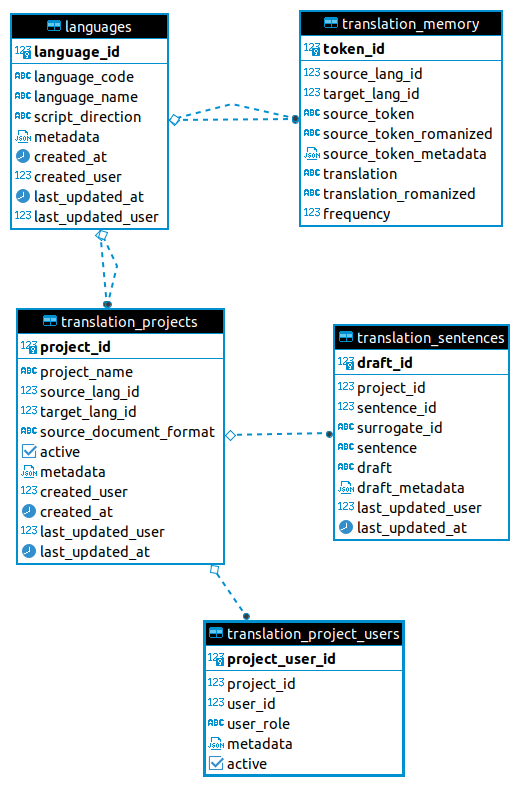

In [72]:
from IPython import display
display.Image("../db/AgMT tables.png")

## Translation Memory

Translation memory, as per the name, is the knowledge base of known translations, which we can use to give suggestions when same or similar tokens are encountered in newer projects. This corresponds to the `translation_memory` table in the database.

#### What is in Translation Memory?
- The token and translation pairs known to us for various source and target languages.
- Metadata about the source tokens if known. Example, if we know that the token is a translation word or key term, then some links or descriptions about it or if we know the word-catogory or morphological features of the token those kinds of information could be stored in here


#### How do we add to Translation memory?
- when users make token replacement on their projects using the API `PUT /v2/autographa/project/tokens` or `/v2/translation/token-translate` and if `useDataForLearning` is `true`.
- when we add lexicons or dictionaries via `POST /v2/translation/learn/gloss` API

#### How and when is Translation Memory used?
For giving translation suggestions for tokens, the suggestions module using trie would be used first and this Translation Memory is used as fall back if trie couldn't give a translation. Here fuzzy string matching is used to account for word inflections and also a reverse search from target to source would also be done to come up with any known translations for the token. The romanized fields of token and translation are used to enable effiecient partial match using soundex.
- The API `GET /v2/translation/gloss` can be used to fetch the known translations and other metadata for token providing the token, source and target languages and optionally a context.
- When sentences are tokenized with `/v2/autographa/project/tokens` or `/v2/translation/tokens` APIs translation suggestions are returned along with tokens if traget is specified. The Translation Memory is used for this.
- When sentences are auto translated using top suggestion via the APIs `/v2/translation/suggestions` and `/v2/autographa/project/suggestions` Translation Memory is used in same way as explianed above to come up with possible replacement for each token in the sentences
- When a set of sentences are tokenized, we refer this Translation Memory to include better possible phrases which have known translations or metadata.

## Sentences and Drafts

All the source text used in a project or uploaded via APIs for generic tokenization, translation or other operations should be split up as sentences as per the logic of the translation project or app. In AgMT, as we work with bible data, one verse is to be considered as a sentence.

For a project on cloud, these sentences and drafts created by token replacement on these sentences are fully stored in the `translation_sentences` table. Whether the source was uploaded as USFM files or was selected from one of the Bibles on the vachan-api cloud, it would be processed and saved as sentences in this table and used from here henceforth.

In [73]:
#project_id = 100000
resp = requests.put(BASE_URL+"autographa/project/suggestions?project_id="+str(project_id)+"&books=mat&books=mrk",
	headers=headers)
resp.json()[0]

{'sentenceId': 41001001,
 'surrogateId': 'mat 1:1',
 'sentence': 'इब्राहीम के वंशज दाऊद के पुत्र यीशु मसीह की वंशावली इस प्रकार है:',
 'draft': 'അബ്രഹാം के वंशज दाऊद के പുത്രന്\u200d യേശു ക്രിസ്തു की वंशावली इस प्रकार है:',
 'draftMeta': [[[0, 8], [0, 7], 'suggestion'],
  [[8, 25], [7, 24], 'untranslated'],
  [[25, 30], [24, 32], 'suggestion'],
  [[30, 31], [32, 33], 'untranslated'],
  [[31, 40], [33, 46], 'suggestion'],
  [[40, 65], [46, 71], 'untranslated']]}

The sentence and draft are stored in the format of alignment.

Conceptually a sentence is considered as one or more segments and so is draft. Then the `draftMeta` stores info about how each segment of sentence is aligned to each segment in draft. The info about how the sentence and drafts are segmented is contained in the draftMeta as offsets. Also it has information about the status of token translation, whether it was translated or confrimed by user(`confirmed`),whether it was populated automatically using the top scored suggestion(`suggestion`) or it is left untranslated(`untranslated`).

#### Advantages of such a format of alignment

* Does not tie the system to Bible content alone.
* Easy Export. Keeping our internal format close to an alignment structure was to make it easy to be exported to alignment formats that can be understood and processed by other Apps and usecases.

* Flexible tokenization. Not saving project wise tokens and translations separately would allow us to give user the freedom of 
    - using single-word, multi-word, even morhpeme level token (what ever we can specify with character offset can become a token)
    - re-tokenizing in-between translation (Example, if user started with tokens excluding functional words and later thought it better to include functional words)
    - altering the auto generated tokens if he finds it appropriate to do so (Example, if the system gave "Jesus" and "christ" as separate tokens, user can combine them to "Jesus Christ" as a single token)

## Suggestions

We try to give context based suggestions for translation of a token(a phrase with one or more word).

The surrounding words of the token in question is considered as its context. Default window_size=5.




In [74]:
import os
notebook_path = os. getcwd()
new_path = notebook_path.replace('vachan-api/docs', 'vachan-api/app')
os.chdir(new_path)

from crud import nlp_crud, utils
from dependencies import get_db
db_session = next(get_db())


In [75]:
suggestion1 = nlp_crud.get_gloss(db_session, 2, ["he", "is", "happy", "today"], 'en', 'ml')
suggestion2 = nlp_crud.get_gloss(db_session, 3, ["he", "is", "not", "happy", "today"], 'en', 'ml')

print("1. ", suggestion1)
print("2. ", suggestion2)

1.  {'token': 'happy', 'translations': {'സന്തോഷവാന്\u200d': 0.5, 'സന്തോഷവാന്\u200d ആയ': 0.5}}
2.  {'token': 'happy', 'translations': {'സന്തോഷവാന്\u200d': 1.2, 'സന്തോഷവാന്\u200d ആയ': 0.4}}


### Building Trie

The data about translation of a token and its context are obtained in the following format. Context in our context is the surrounding words of the token. We use a default `windows_size=5`, which can be changed, if required

`(token-index, ['list', 'of', 'context', 'words', 'including', 'token'], translation)`

In [76]:
sample_data = [(2, ["Always", "the", "duck", "quacks"], "താറാവ്")]

sample_trie = nlp_crud.build_trie(sample_data)
nlp_crud.display_tree(sample_trie)

	- duck	- L:the	- R:quacks	- L:Always =>  {'താറാവ്': 0.5}
	- duck	- R:quacks	- L:the	- L:Always =>  {'താറാവ്': 0.5}


In [53]:
sample_data.append((1,["we","duck", "down", "on", "warning"], "കുനിയും"))
sample_trie = nlp_crud.build_trie(sample_data)
nlp_crud.display_tree(sample_trie)

	- duck	- L:the	- R:quacks	- L:Always =>  {'താറാവ്': 0.5}
	- duck	- R:quacks	- L:the	- L:Always =>  {'താറാവ്': 0.5}
	- duck	- L:we	- R:down	- R:on	- R:warning =>  {'കുനിയും': 0.5}
	- duck	- R:down	- L:we	- R:on	- R:warning =>  {'കുനിയും': 0.5}


The reasons for forming trie in this structure are
- matching/searching should start from the token, which might be at the center of the context. Hence me bring token to the root node and add one word per level as we go deep
- quering with only right side words, only left side words and both side words should all be successful. Hence adding multiple paths covering all possible sequences

### Querying Trie

We have to perform same operartions we did on traning data, to the new input token and context and convert it into a sequence like the trie paths we have. Then querying trie would give us a context based, scored suggestions

In [55]:
def convert_context_to_keys(index, context):
    word = context[index]
    to_left = [context[i] for i in range(index-1, -1, -1)]
    to_right = context[index+1:]
    keys = nlp_crud.form_trie_keys(word, to_left, to_right, [word], False)
    return keys

def suggestions(tree, keys):
    suggs = {}
    for key in keys:
        if tree.has_subtrie(key) or tree.has_key(key):
            for val in tree.values(key):
                trans, score = list(val.items())[0]
                if trans not in suggs:
                    suggs[trans] = score
                else:
                    suggs[trans] += score
    return suggs
    
keys = convert_context_to_keys(1, ["the", "duck", "tastes", "good"])
# print(keys)
suggestions(sample_trie, keys)

{'താറാവ്': 1.5, 'കുനിയും': 1.0}

In [56]:
keys = convert_context_to_keys(2, ["the", "black", "duck", "quacks"])
suggestions(sample_trie, keys)

{'താറാവ്': 2.0, 'കുനിയും': 1.0}

In [57]:
keys = convert_context_to_keys(1, ["we", "duck", "on", "loud", "crack"])
suggestions(sample_trie, keys)

{'കുനിയും': 1.5, 'താറാവ്': 1.0}

In [58]:
keys = convert_context_to_keys(0, ["duck", "down", "if", "you", "hear"])
suggestions(sample_trie, keys)

{'കുനിയും': 1.5, 'താറാവ്': 1.0}

### Collecting Data for Trie

This data is obtained from
- confirmed translations in the projects on cloud
- alignments loaded to the server

#### From Translation Projects

In [77]:
import db_models
db_session = next(get_db())
resp = requests.put(BASE_URL+"autographa/project/suggestions?project_id="+str(project_id)+"&confirm_all=true",
	headers=headers)


In [78]:
sentence_list = db_session.query(db_models.TranslationDraft).filter(
        db_models.TranslationDraft.project_id==project_id).all()
training_data1 = nlp_crud.get_training_data_from_drafts(sentence_list, window_size=5)
training_data1

[(2, ['हम', 'तक', 'पहुँचाया।'], 'പ്രാപിക്കേണ്ടതിന്'),
 (2, ['आदि', 'में', 'परमेश्वर', 'के', 'साथ', 'था'], 'ദൈവം'),
 (0, ['इब्राहीम', 'का', 'पुत्र', 'था'], 'അബ്രഹാം'),
 (2, ['इब्राहीम', 'का', 'पुत्र', 'था', 'इसहाक', 'और'], 'പുത്രന്\u200d'),
 (2, ['इसहाक', 'का', 'पुत्र', 'हुआ', 'याकूब', 'फिर'], 'പുത്രന്\u200d'),
 (2, ['तूने', 'शिक्षा', 'पाई', 'है', 'कैसी', 'अटल'], 'പ്രാപിക്കേണ്ടതിന്'),
 (2, ['और', 'वचन', 'परमेश्वर', 'के', 'साथ', 'था'], 'ദൈവം'),
 (2, ['और', 'वचन', 'परमेश्वर', 'था'], 'ദൈവം'),
 (1, ['यह', 'परमेश्वर', 'के', 'पुत्र', 'यीशु'], 'ദൈവം'),
 (2, ['परमेश्वर', 'के', 'पुत्र', 'यीशु', 'मसीह', 'के'], 'പുത്രന്\u200d'),
 (2, ['के', 'पुत्र', 'यीशु मसीह', 'के', 'शुभ', 'संदेश'], 'യേശു ക്രിസ്തു'),
 (0, ['इब्राहीम', 'के', 'वंशज', 'दाऊद'], 'അബ്രഹാം'),
 (2, ['दाऊद', 'के', 'पुत्र', 'यीशु', 'मसीह', 'की'], 'പുത്രന്\u200d'),
 (2, ['के', 'पुत्र', 'यीशु मसीह', 'की', 'वंशावली', 'इस'], 'യേശു ക്രിസ്തു')]

In [61]:
trie = nlp_crud.build_trie(training_data1)
nlp_crud.display_tree(trie)

	- पहुँचाया।	- L:तक	- L:हम =>  {'പ്രാപിക്കേണ്ടതിന്': 1.0}
	- परमेश्वर	- L:में	- R:के	- L:आदि	- R:साथ	- R:था =>  {'ദൈവം': 0.25}
	- परमेश्वर	- L:में	- R:के	- R:साथ	- L:आदि	- R:था =>  {'ദൈവം': 0.25}
	- परमेश्वर	- R:के	- L:में	- L:आदि	- R:साथ	- R:था =>  {'ദൈവം': 0.25}
	- परमेश्वर	- R:के	- L:में	- R:साथ	- L:आदि	- R:था =>  {'ദൈവം': 0.25}
	- परमेश्वर	- R:के	- L:वचन	- L:और	- R:साथ	- R:था =>  {'ദൈവം': 0.25}
	- परमेश्वर	- R:के	- L:वचन	- R:साथ	- L:और	- R:था =>  {'ദൈവം': 0.25}
	- परमेश्वर	- R:के	- L:यह	- R:पुत्र	- R:यीशु =>  {'ദൈവം': 0.5}
	- परमेश्वर	- L:वचन	- R:के	- L:और	- R:साथ	- R:था =>  {'ദൈവം': 0.25}
	- परमेश्वर	- L:वचन	- R:के	- R:साथ	- L:और	- R:था =>  {'ദൈവം': 0.25}
	- परमेश्वर	- L:वचन	- R:था	- L:और =>  {'ദൈവം': 0.5}
	- परमेश्वर	- R:था	- L:वचन	- L:और =>  {'ദൈവം': 0.5}
	- परमेश्वर	- L:यह	- R:के	- R:पुत्र	- R:यीशु =>  {'ദൈവം': 0.5}
	- इब्राहीम	- R:के	- R:वंशज	- R:दाऊद =>  {'അബ്രഹാം': 1.0}
	- इब्राहीम	- R:का	- R:पुत्र	- R:था =>  {'അബ്രഹാം': 1.0}
	- पुत्र	- L:के	- R:यीशु	- L:दाऊद	- R:मसीह	- R:की

#### From alignments and dictionaries

In [62]:
ALIGNMENT_SRC = "hi"
ALIGNMENT_TRG = "ml"
alignment_data = [
{
    "sourceTokenList": [
      "क्योंकि","परमेश्वर","ने","जगत","से","ऐसा","प्रेम","रखा","कि","उसने",
      "अपना","एकलौता","पुत्र","दे","दिया","ताकि","जो","कोई","उस","पर","विश्वास","करे",
      "वह","नाश","न","हो","परन्तु","अनन्त","जीवन","पाए"
    ],
    "targetTokenList": [
      "തന്റെ",
      "ഏകജാതനായ","പുത്രനിൽ",
      "വിശ്വസിക്കുന്ന","ഏവനും","നശിച്ചുപോകാതെ","നിത്യജീവൻ",
      "പ്രാപിക്കേണ്ടതിന്","ദൈവം","അവനെ","നല്കുവാൻ","തക്കവണ്ണം",
      "ലോകത്തെ","സ്നേഹിച്ചു"
    ],
    "alignedTokens": [
      {
        "sourceTokenIndex": 1,
        "targetTokenIndex": 8
      },
      {
        "sourceTokenIndex": 2,
        "targetTokenIndex": 8
      },
      {
        "sourceTokenIndex": 3,
        "targetTokenIndex": 12
      },
      {
        "sourceTokenIndex": 4,
        "targetTokenIndex": 12
      },
      {
        "sourceTokenIndex": 5,
        "targetTokenIndex": 11
      },
      {
        "sourceTokenIndex": 6,
        "targetTokenIndex": 13
      },
      {
        "sourceTokenIndex": 7,
        "targetTokenIndex": 13
      },
      {
        "sourceTokenIndex": 8,
        "targetTokenIndex": 13
      },
      {
        "sourceTokenIndex": 9,
        "targetTokenIndex": 0
      },
      {
        "sourceTokenIndex": 10,
        "targetTokenIndex": 0
      },
      {
        "sourceTokenIndex": 11,
        "targetTokenIndex": 1
      },
      {
        "sourceTokenIndex": 12,
        "targetTokenIndex": 1
      },
      {
        "sourceTokenIndex": 11,
        "targetTokenIndex": 2
      },
      {
        "sourceTokenIndex": 12,
        "targetTokenIndex": 2
      },
      {
        "sourceTokenIndex": 13,
        "targetTokenIndex": 10
      },
      {
        "sourceTokenIndex": 14,
        "targetTokenIndex": 10
      },
      {
        "sourceTokenIndex": 20,
        "targetTokenIndex": 3
      },
      {
        "sourceTokenIndex": 21,
        "targetTokenIndex": 3
      },
      {
        "sourceTokenIndex": 18,
        "targetTokenIndex": 4
      },
      {
        "sourceTokenIndex": 19,
        "targetTokenIndex": 4
      },

      {
        "sourceTokenIndex": 23,
        "targetTokenIndex": 5
      },
      {
        "sourceTokenIndex": 24,
        "targetTokenIndex": 5
      },
      {
        "sourceTokenIndex": 25,
        "targetTokenIndex": 5
      },
      {
        "sourceTokenIndex": 27,
        "targetTokenIndex": 6
      },
      {
        "sourceTokenIndex": 28,
        "targetTokenIndex": 6
      },
      {
        "sourceTokenIndex": 29,
        "targetTokenIndex": 7
      }
	]
}
]

In [63]:
from math import floor, ceil
import schemas_nlp

def convert_object_type(input_obj, target_class):
    '''convert a graphene input object into specified pydantic model'''
    kwargs = {}
    for key in input_obj:
        kwargs[key] = input_obj[key]
    new_obj = target_class(**kwargs)
    return new_obj

def alignments_to_trainingdata(src_lang, trg_lang, alignment_list, window_size=5):
    '''Convert alignments to training data for suggestions module and also add to translation_memory
    input format: [(<src sent>,<trg_sent>,[(0-0), (1-3),(2-1),..]]
    output: <index>\t<context ayrray>\t<translation>'''
    dict_data = {}
    sugg_data = []
    for sent in alignment_list:
        src_len = len(sent.sourceTokenList)
        phrases = nlp_crud.find_pharses_from_alignments(sent.sourceTokenList, sent.targetTokenList,
            sent.alignedTokens)
        for obj in phrases:
            ## prepare data for translation memory/gloss
            if obj["token"] in dict_data:
                dict_data[obj["token"]]['translations'].append(obj['translation'])
            else:
                dict_data[obj["token"]] = {"token": obj["token"],
                "translations":[obj['translation']]}
            ## prepare data for suggestions trie
            end = obj['src_indices'][0]
            if end == 0:
                pre_context = []
            elif end-ceil(window_size/2) >= 0:
                start = end-ceil(window_size/2)
                pre_context = sent.sourceTokenList[start:end]
            else:
                pre_context = sent.sourceTokenList[0:end]
            start = obj['src_indices'][-1]+1
            if start == src_len:
                post_context = []
            elif start + floor(window_size/2) <= src_len:
                end = start + floor(window_size/2)
                post_context = sent.sourceTokenList[start:end]
            else:
                post_context = sent.sourceTokenList[start:]
            # split multiword tokens in context
            pre_context = ' '.join(pre_context).split(' ')
            post_context = ' '.join(post_context).split(' ')

            context = pre_context + [obj['token']] + post_context
            sugg_data.append((len(pre_context), context, obj['translation']))
    return sugg_data

alignment_list = [convert_object_type(item, schemas_nlp.Alignment) for item in alignment_data]
training_data2 = alignments_to_trainingdata(ALIGNMENT_SRC, ALIGNMENT_TRG, alignment_list)   
training_data2

[(1, ['क्योंकि', 'परमेश्वर ने', 'जगत', 'से'], 'ദൈവം'),
 (3, ['क्योंकि', 'परमेश्वर', 'ने', 'जगत से', 'ऐसा', 'प्रेम'], 'ലോകത്തെ'),
 (3, ['ने', 'जगत', 'से', 'ऐसा', 'प्रेम', 'रखा'], 'തക്കവണ്ണം'),
 (3, ['जगत', 'से', 'ऐसा', 'प्रेम रखा कि', 'उसने', 'अपना'], 'സ്നേഹിച്ചു'),
 (3, ['प्रेम', 'रखा', 'कि', 'उसने अपना', 'एकलौता', 'पुत्र'], 'തന്റെ'),
 (3, ['अपना', 'एकलौता', 'पुत्र', 'दे दिया', 'ताकि', 'जो'], 'നല്കുവാൻ'),
 (3, ['कोई', 'उस', 'पर', 'विश्वास करे', 'वह', 'नाश'], 'വിശ്വസിക്കുന്ന'),
 (3, ['ताकि', 'जो', 'कोई', 'उस पर', 'विश्वास', 'करे'], 'ഏവനും'),
 (3, ['विश्वास', 'करे', 'वह', 'नाश न हो', 'परन्तु', 'अनन्त'], 'നശിച്ചുപോകാതെ'),
 (3, ['न', 'हो', 'परन्तु', 'अनन्त जीवन', 'पाए'], 'നിത്യജീവൻ'),
 (3, ['परन्तु', 'अनन्त', 'जीवन', 'पाए', ''], 'പ്രാപിക്കേണ്ടതിന്')]

In [64]:
trie = nlp_crud.build_trie(training_data2)
nlp_crud.display_tree(trie)

	- परमेश्वर ने	- L:क्योंकि	- R:जगत	- R:से =>  {'ദൈവം': 0.5}
	- परमेश्वर ने	- R:जगत	- L:क्योंकि	- R:से =>  {'ദൈവം': 0.5}
	- जगत से	- L:ने	- R:ऐसा	- L:परमेश्वर	- R:प्रेम	- L:क्योंकि =>  {'ലോകത്തെ': 0.25}
	- जगत से	- L:ने	- R:ऐसा	- R:प्रेम	- L:परमेश्वर	- L:क्योंकि =>  {'ലോകത്തെ': 0.25}
	- जगत से	- R:ऐसा	- L:ने	- L:परमेश्वर	- R:प्रेम	- L:क्योंकि =>  {'ലോകത്തെ': 0.25}
	- जगत से	- R:ऐसा	- L:ने	- R:प्रेम	- L:परमेश्वर	- L:क्योंकि =>  {'ലോകത്തെ': 0.25}
	- ऐसा	- L:से	- R:प्रेम	- L:जगत	- R:रखा	- L:ने =>  {'തക്കവണ്ണം': 0.25}
	- ऐसा	- L:से	- R:प्रेम	- R:रखा	- L:जगत	- L:ने =>  {'തക്കവണ്ണം': 0.25}
	- ऐसा	- R:प्रेम	- L:से	- L:जगत	- R:रखा	- L:ने =>  {'തക്കവണ്ണം': 0.25}
	- ऐसा	- R:प्रेम	- L:से	- R:रखा	- L:जगत	- L:ने =>  {'തക്കവണ്ണം': 0.25}
	- प्रेम रखा कि	- L:ऐसा	- R:उसने	- L:से	- R:अपना	- L:जगत =>  {'സ്നേഹിച്ചു': 0.25}
	- प्रेम रखा कि	- L:ऐसा	- R:उसने	- R:अपना	- L:से	- L:जगत =>  {'സ്നേഹിച്ചു': 0.25}
	- प्रेम रखा कि	- R:उसने	- L:ऐसा	- L:से	- R:अपना	- L:जगत =>  {'സ്നേഹിച്ചു': 0.25}
	- प्रेम रखा कि	- R:उस

### Saving and Loading Trie

- Saving
    * for tries built from uploaded alignment data, we save the model as a JSON can can be easily loaded back when required. Naming of the JSON file is as per the following pattern, `<src_lang>-<trg_lang>-<user_id>--<timestamp>.json` which will allow us to identify and remove data if required which are uploaded separately.
    * As data in project draft may always change, tries are built from them dynamically as and when required.
    
- Loading

    We keep all the tries that were used in the App's running time in the memory itself as `suggestion_trie_in_mem[source_lang+"-"+target_lang] = trie` 


### Fall back to Translation Memory

Translation Memory table is the fall back, if the trie could not give a suggestion. But these suggestions given by TM are not based on context.

What more does Translation Memory offer?
- Only data obtained from translation projects on server and alignments loaded on server are available in trie. There are other ways we can get token translations without context, which are stored in TM.
    * From dictionaries and lexicons loaded directly to server
    * Token translations done on data that are not saved in projects on cloud
- Only one directional, source to target, info is available in tries. We can query the TM in the reverse order, if a forward match is not found.
- Only exact matching is done on trie's tokens. We can go for a fuzzy match in the absence of exact matching and give useful suggestions when we know translations of slightly different token, thus tackle inflectional changes.

In [65]:
import os
notebook_path = os. getcwd()
new_path = notebook_path.replace('vachan-api/docs', 'vachan-api/app')
os.chdir(new_path)

from crud import nlp_crud, utils
from dependencies import get_db
db_session = next(get_db())

nlp_crud.glossary(db_session, "hi", "ml", "पुत्र")

{'token': 'पुत्र', 'translations': {'പുത്രന്\u200d': 2.0}, 'metaData': None}

In [66]:
nlp_crud.glossary(db_session, "ml", "hi", "പുത്രന്‍")

{'token': 'പുത്രന്\u200d', 'translations': {'पुत्र': 2.0}}

In [67]:
nlp_crud.glossary(db_session, "ml", "hi", "പുത്രന്റെ")

{'token': 'പുത്രന്\u200d', 'translations': {'पुत्र': 0.6666666666666666}}

In [68]:
nlp_crud.glossary(db_session, "ml", "hi", "പുത്രന്റെയും")

{'token': 'പുത്രന്\u200d', 'translations': {'पुत्र': 0.5}}

In [69]:
nlp_crud.glossary(db_session, "hi","ml", "कहानी")

{'token': 'कहानी', 'translations': {'കഥ': 1.0}, 'metaData': None}

In [70]:
nlp_crud.glossary(db_session, "hi","ml", "कहानीयों")

{'token': 'कहानी', 'translations': {'കഥ': 0.3333333333333333}}